# Variational Mixture of Gaussians

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas as pd

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (8, 4)

In [3]:
url = ("https://gist.githubusercontent.com/curran/"
       "4b59d1046d9e66f2787780ad51a1cd87/raw/"
       "9ec906b78a98cf300947a37b56cfe70d01183200/data.tsv")

Let ${\bf X} = \{x_n\}_{n=1}^N$ a dataset of i.i.d. mixture of Gaussians with parameters $\boldsymbol \pi = \{\pi_k\}_{k=1}^K$, $\boldsymbol \mu= \{\mu_k\}_{k=1}^K$, $\boldsymbol \Lambda= \{\Lambda_k\}_{k=1}^K$ and latent variables ${\bf Z}=\{z_n\}_n$.

The likelihood distribution is defined to be

$$
\begin{aligned}
    p({\bf x} \vert {\bf z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \lambda}) &= p({\bf x} \vert {\bf z}, {\boldsymbol \mu}, {\boldsymbol \lambda}) p({\bf z} \vert {\boldsymbol \pi}) \\
    &= \prod_{n=1}^N\prod_{k=1}^K \mathcal{N}\left(x_n \vert \mu_k, \Lambda_k^{-1}\right)^{z_{nk}} \cdot \prod_{n=1}^N\prod_{k=1}^K \pi_k^{z_{nk}}
\end{aligned}
$$

Thus, the full joint distribution factorizes as follows:

$$
\begin{aligned}
p({\bf x} , {\bf z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \lambda}) &= p({\bf x} \vert {\bf z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \lambda}) p({\bf z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \lambda}) \\
&= p({\bf x} \vert {\bf z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \lambda}) p(\boldsymbol \pi) p({\bf z} \vert \boldsymbol \pi) p(\boldsymbol \mu \vert \boldsymbol \Lambda) p(\boldsymbol \Lambda)
\end{aligned} 
$$

We now introduce conjugate priors of the form

$$
    p(\boldsymbol\pi) = \text{Dir}(\boldsymbol \pi \vert \alpha_0)
$$

$$
   p(\boldsymbol\mu\vert\boldsymbol\Lambda) = \prod_{k=1}^K \mathcal{N}\left(\mu_k\vert{\bf m}_0, (\beta_0\Lambda_k)^{-1}\right)
$$

$$
   p(\boldsymbol\Lambda) = \prod_{k=1}^K \mathcal{W}(\Lambda_k\vert{\bf W}_0, \nu_0)
$$

Next, we consider a variational distribution that factorizes between latent variables ($\bf z$) and parameters ($\boldsymbol\pi, \boldsymbol\mu, \boldsymbol\Lambda$):

$$
    q({\bf z}, \boldsymbol\pi, \boldsymbol\mu, \boldsymbol\Lambda) = q({\bf z})q(\boldsymbol\pi, \boldsymbol\mu, \boldsymbol\lambda)
$$

---

In general, a factorized variational approximation to a full joint distribution of observed variables ($\bf x$) and hidden variables ($\bf z$) satisfies

$$
    \log q_j^*(z_j) = \mathbb{E}_{m\neq j}\left[\log p({\bf x}, {\bf z})\right] + C
$$


Which involves the following computation for our problem:

$$
    \log q({\bf z}) = \mathbb{E}_{\boldsymbol\pi, \boldsymbol\mu, \boldsymbol\Lambda}\left[\log p({\bf x} , {\bf z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \lambda})\right] + C
$$

$$
    \log q(\boldsymbol\pi, \boldsymbol\mu, \boldsymbol\Lambda) = \mathbb{E}_{\bf z}\left[\log p({\bf x} , {\bf z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \lambda})\right] + C
$$

It turns out that 

$$
    q^*({\bf z}) = \prod_{n=1}^N\prod_{k=1}^K r_{nk}^{z_{nk}}
$$

With 
* $r_{nk} = \frac{\rho_{nk}}{\sum_j\rho_{nj}}$,
* $\log \rho_{nk} = \mathbb{E}_{\pi}[\log \pi_k] + \frac{1}{2}\mathbb{E}_{\boldsymbol \Lambda}[\log\vert\Lambda_k\vert] - \frac{M}{2}\log 2\pi - \frac{1}{2}\mathbb{E}_{\boldsymbol \mu, \boldsymbol \Lambda}\left[(x_n - \mu_k)^T\Lambda_k(x_n - \mu_k)\right]$
    * $\mathbb{E}_{\pi}[\log \pi_k] = \psi(\alpha_k) - \psi(\hat{\boldsymbol\alpha})$
    * $\mathbb{E}_{\boldsymbol \Lambda}\left[\log\vert\Lambda_k\vert\right] = \sum_{m=1}^M\psi\left(\frac{\nu_k + 1 - M}{2}\right) + M\log2 + \log\vert{\bf w}_k\vert$
    * $\mathbb{E}_{\boldsymbol \mu, \boldsymbol \Lambda}\left[(x_n - \mu_k)^T\Lambda_k(x_n - \mu_k)\right] = \nu_k(x_n - {\bf m}_k)^T {\bf w}_k(x_n - {\bf m}_k) + M\beta^{-1}_k$


* $\psi(a) = \frac{d}{da}\Gamma(a)$
* $\hat{\boldsymbol\alpha} = \sum_k\alpha_k$

---


$$
    q^*(\boldsymbol\pi) = \text{Dir}(\boldsymbol\pi | \boldsymbol\alpha)
$$

With
* $\boldsymbol\alpha_k = \alpha_0 + N_k$

---

$$
    q^{*}(\mu_k |  \Lambda_k) = \mathcal{N}\left(\mu_k |  {\bf m}_k, (\beta_k \Lambda_k)^{-1}\right)
$$

With
* $\beta_k = \beta_0 + N_k$
* ${\bf m}_k = \frac{1}{\beta_k}(\beta_0{\bf m}_0 + N_k\bar{\bf x}_k)$

---

$$
    q^{*}(\Lambda_k) = \mathcal{W}(\Lambda_k | {\bf w}_k, \nu_k)
$$

With
* $\nu_k$ = $\nu_0 + N_k$
* ${\bf w}_k^{-1} = {\bf w}_0 + N_kS_k + \frac{\beta_0N_k}{\beta_0 + N_k}(\bar{\bf x}_k - {\bf m}_0)(\bar{\bf x}_k - {\bf m}_0)^T$


Where we have defined

$$
    N_k = \sum_{n=1}^N r_{nk}
$$

$$
    \bar{\bf x}_k = \frac{1}{N_k}\sum_{n=1}^N r_{nk} {\bf x}_n
$$

$$
    S_k = \frac{1}{N_k}\sum_{n=1}^N r_{nk} \big({\bf x}_n - \bar{\bf x}_k\big)\big({\bf x}_n - \bar{\bf x}_k\big)^T
$$

In [4]:
old_faithful = pd.read_table(url)

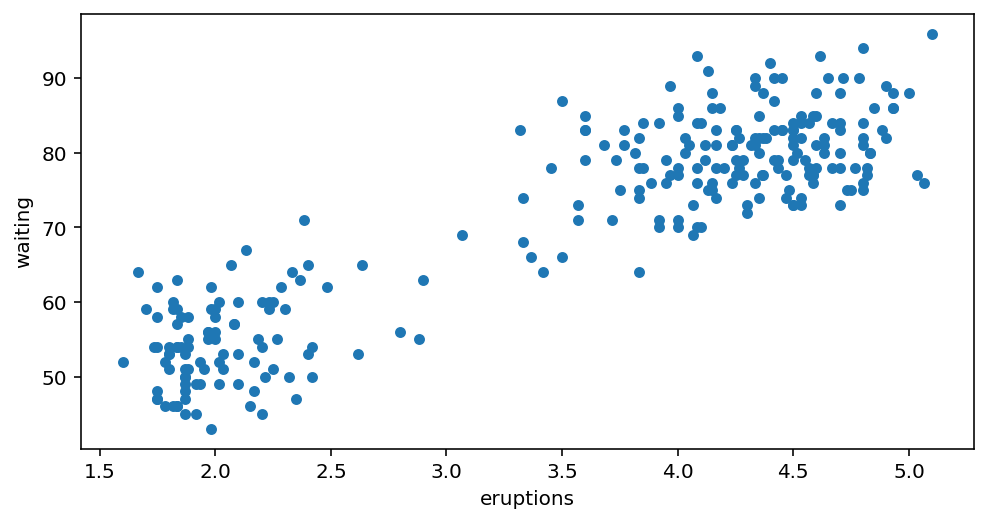

In [5]:
old_faithful.plot.scatter(x="eruptions", y="waiting")

# Variational E-step

Our first step in estimating a mixture density over the `old_faithful` dataset is to compute the responsibilities $r_{nk}$